# Enabling Portable and Reproducible Long-term Thermal Comfort Evaluation with Brick Schema and Mortar Testbed

## Quick Overview  
We use <a href='https://brickschema.org/'>Brick</a> and <a href='https://mortardata.org/intro.html'>Mortar</a> to evalute long-term thermal comfort across 25 buildings. All analysis and findings in our ASHRAE 2022 Annual Conference Paper are reproducible here. You don't need to fully understand the technology of Brick and Mortar to execute this notebook. Feel free to try something different. Have fun! If you have any questions, feel free to contact ruijis@berkeley.edu </br>

(Release soon) Ruiji Sun, Carlos Duarte Roa, Paul Raftery, and Gabe Fierro."Enabling Portable and Reproducible Long-term Thermal Comfort Evaluation with Brick Schema and Mortar Testbed." ASHRAE 2022 </br>

v0.8; December 2021 

## 1. Query Brick models that have Zone_Air_Temp Sensor points

![alt text](brickclassmodel.png "Title")

In [1]:
from air_temp_based_indices import *
import pymortar
# connect a client to Mortar backend server
client = pymortar.Client("https://beta-api.mortardata.org")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
# display all content in a dataframe column
pd.set_option('display.max_colwidth', None)
# discard warning info
pd.set_option('mode.chained_assignment', None)

In [2]:
# SPAQRL query of Brick model that have zone air temperature sensor, vav, etc.
query = """SELECT ?sensor ?zone ?vav ?room ?floor ?ahu WHERE {{
    ?sensor a brick:Zone_Air_Temperature_Sensor .
    ?sensor brick:isPointOf ?vav .
    ?vav brick:feeds ?zone .
    ?zone a brick:HVAC_Zone .
    ?zone brick:hasPart ?room .
    ?room a brick:Room .
    ?room brick:isPartOf ?floor .
    ?floor a brick:Floor .
    ?ahu a brick:AHU .
    ?ahu brick:feeds ?vav .
}}"""

In [5]:
# filter out buildings that satisfy the query above
qualify_resp = client.qualify([query])
print("Mortar has {0} qualifed sites".format(len(qualify_resp.sites)))
print(qualify_resp.sites)

Mortar has 25 qualifed sites
['artx', 'bwfp', 'chem', 'chemx', 'crus', 'dh', 'fdpd', 'gbsf', 'gha_ics', 'giedt', 'hart', 'hwc', 'mann', 'msb', 'music', 'roes', 'stor', 'thur', 'veih', 'vm3a', 'vmep', 'vmif', 'vmth', 'well', 'wsrc']


## 2. Long-term thermal comfort indices Pearson correlation
### 2.1 Calculate indices at one building
We randomly select one building from the 25 sites above. Each row corresponds to one zone air temperature sensor and related entities. We then download each sensor's data and calculate it's long-term thermal comfort index value.

In [55]:
random_bldg = client.sparql(query, sites=[random.choice(qualify_resp.sites)])
random_bldg

sensor  \
0   http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM146_MIX.Zone_Air_Temp   
1       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM147.Zone_Air_Temp   
2   http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM147_MIX.Zone_Air_Temp   
3       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM145.Zone_Air_Temp   
4   http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM145_MIX.Zone_Air_Temp   
5       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU05.RM142.Zone_Air_Temp   
6       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM149.Zone_Air_Temp   
7       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU05.RM150.Zone_Air_Temp   
8       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU05.RM151.Zone_Air_Temp   
9       http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM141.Zone_Air_Temp   
10      http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU05.RM153.Zone_Air_Temp   
11      http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM146.Zone_Air_Temp   
12  http://buildsys.org/ontologies/MANN#MANN.ZONE.AHU06.RM141_MIX.Zone_Air_Temp   

                                             zone  \
0   http://buildsys.org/ontologies/MANN#RM146_MIX   
1       http://buildsys.org/ontologies/MANN#RM147   
2   http://buildsys.org/ontologies/MANN#RM147_MIX   
3       http://buildsys.org/ontologies/MANN#RM145   
4   http://buildsys.org/ontologies/MANN#RM145_MIX   
5       http://buildsys.org/ontologies/MANN#RM142   
6       http://buildsys.org/ontologies/MANN#RM149   
7       http://buildsys.org/ontologies/MANN#RM150   
8       http://buildsys.org/ontologies/MANN#RM151   
9       http://buildsys.org/ontologies/MANN#RM141   
10      http://buildsys.org/ontologies/MANN#RM153   
11      http://buildsys.org/ontologies/MANN#RM146   
12  http://buildsys.org/ontologies/MANN#RM141_MIX   

                                                 vav  \
0   http://buildsys.org/ontologies/MANN#VAVRM146_MIX   
1       http://buildsys.org/ontologies/MANN#VAVRM147   
2   http://buildsys.org/ontologies/MANN#VAVRM147_MIX   
3       http://buildsys.org/ontologies/MANN#VAVRM145   
4   http://buildsys.org/ontologies/MANN#VAVRM145_MIX   
5       http://buildsys.org/ontologies/MANN#VAVRM142   
6       http://buildsys.org/ontologies/MANN#VAVRM149   
7       http://buildsys.org/ontologies/MANN#VAVRM150   
8       http://buildsys.org/ontologies/MANN#VAVRM151   
9       http://buildsys.org/ontologies/MANN#VAVRM141   
10      http://buildsys.org/ontologies/MANN#VAVRM153   
11      http://buildsys.org/ontologies/MANN#VAVRM146   
12  http://buildsys.org/ontologies/MANN#VAVRM141_MIX   

                                                  room  \
0   http://buildsys.org/ontologies/MANN#RM146_MIX_room   
1       http://buildsys.org/ontologies/MANN#RM147_room   
2   http://buildsys.org/ontologies/MANN#RM147_MIX_room   
3       http://buildsys.org/ontologies/MANN#RM145_room   
4   http://buildsys.org/ontologies/MANN#RM145_MIX_room   
5       http://buildsys.org/ontologies/MANN#RM142_room   
6       http://buildsys.org/ontologies/MANN#RM149_room   
7       http://buildsys.org/ontologies/MANN#RM150_room   
8       http://buildsys.org/ontologies/MANN#RM151_room   
9       http://buildsys.org/ontologies/MANN#RM141_room   
10      http://buildsys.org/ontologies/MANN#RM153_room   
11      http://buildsys.org/ontologies/MANN#RM146_room   
12  http://buildsys.org/ontologies/MANN#RM141_MIX_room   

                                         floor  \
0   http://buildsys.org/ontologies/MANN#floor1   
1   http://buildsys.org/ontologies/MANN#floor1   
2   http://buildsys.org/ontologies/MANN#floor1   
3   http://buildsys.org/ontologies/MANN#floor1   
4   http://buildsys.org/ontologies/MANN#floor1   
5   http://buildsys.org/ontologies/MANN#floor1   
6   http://buildsys.org/ontologies/MANN#floor1   
7   http://buildsys.org/ontologies/MANN#floor1   
8   http://buildsys.org/ontologies/MANN#floor1   
9   http://buildsys.org/ontologies/MANN#floor1   
10  http://buildsys

In [3]:
# users can specify customized input values
# summer start month, the cooling season: 5, 6, 7, 8, 9, 10
ss = 5
# winter start month, the heating season: 11, 12, 1, 2, 3, 4
ws = 11
# start date, with format year-month-day,
sd = '2016-1-1'
# end date, with format year-month-day
ed = '2016-12-31'
# start hour of normal occupied time, with 24-hour clock
sh = 9
# end hour of normal occupied time, with 24-hour clock
eh = 17
# lower bound of the tempearture range in summer, with default F unit
sl = 71.6
# upper bound of the temperature range in summer, with default F unit
su = 80.6
# lower bound of the tempearture range in winter, with default F unit
wl = 66.2
# upper bound of the temperature range in winter, with default F unit
wu = 77.0
# threshold of daily temperature range, with default F unit
th = 2

In [57]:
random_cor = []
for idxi, row in random_bldg.iterrows():
    random_cor_row = {}
    md = row.sensor
    # calculate indices
    i_mean = temp_mean(md, sd, ed, sh, eh)
    i_var = temp_var(md, sd, ed, sh, eh)
    i_dh = degree_hours(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
    i_ro = range_outlier(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
    i_dro = daily_range_outlier(md, sd, ed, sh, eh, th)
    i_c = combined_outlier(i_ro, i_dro)
    # assign each index values to a column in the dictionary
    random_cor_row['Temp Mean'] = i_mean
    random_cor_row['Temp Variance'] = i_var
    random_cor_row['Degree Hours'] = i_dh
    random_cor_row['Range Outlier'] = i_ro
    random_cor_row['Daily Range Outlier'] = i_dro
    random_cor_row['Combined Outlier'] = i_c
    random_cor += [random_cor_row]
# assign result to a dataframe
random_cor_df = pd.DataFrame(random_cor)

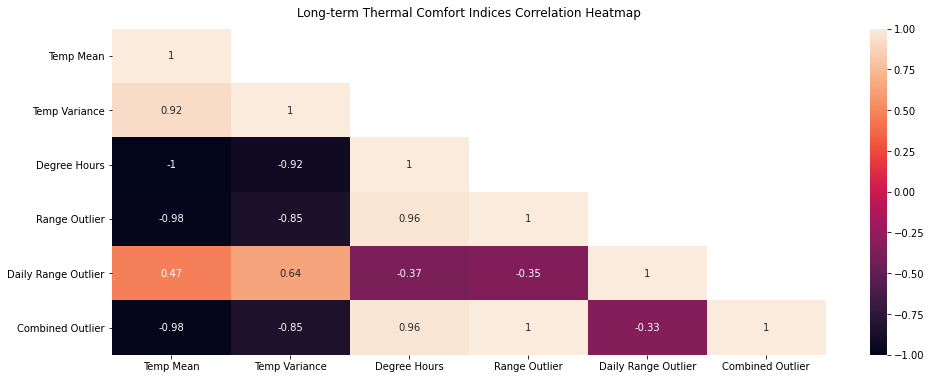

In [59]:
# plot Pearson correlation heatmap
plt.figure(figsize=(16, 6))
# creat a mask showing only the lower part of the heatmap
mask = np.triu(np.ones_like(random_cor_df.corr()))
np.fill_diagonal(mask, 0)
heatmap = sns.heatmap(random_cor_df.corr(), vmin=-1, vmax=1, annot=True, mask=mask)
heatmap.set_title('Long-term Thermal Comfort Indices Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

### 2.2 Calcuate indices across all 25 buildings
The graph above shows the correlation analysis between each two indices at a randomly select one building. Some correlation coefficents are not reasonable. Therefore, we execute the same analysis, but across all 25 qualified sites. In this way, we fully take the portbale and reproducible advantage of Mortar testbed. Please note that this step would require 30 mintues or even longer time to finish.

In [14]:
# get the brick metadata of the query sensors across all sites, except 'vmif'
meta_all = client.sparql(query, sites=qualify_resp.sites)
cor = []
for idxi, row in meta_all.iterrows():
    cor_row = {}
    md = row.sensor
    md_end = re.split('[.]', md)[-1]
    # Brick models might have instances belonging to the wrong classes 
    # filter out the wrong sensors before calculating metrics on them
    if md_end == "Zone_Air_Temp":
        # calculate indices
        i_mean = temp_mean(md, sd, ed, sh, eh)
        i_var = temp_var(md, sd, ed, sh, eh)
        i_dh = degree_hours(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
        i_ro = range_outlier(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
        i_dro = daily_range_outlier(md, sd, ed, sh, eh, th)
        i_c = combined_outlier(i_ro, i_dro)
        # assign each index values to a column in the dictionary
        cor_row['Temp Mean'] = i_mean
        cor_row['Temp Variance'] = i_var
        cor_row['Degree Hours'] = i_dh
        cor_row['Range Outlier'] = i_ro
        cor_row['Daily Range Outlier'] = i_dro
        cor_row['Combined Outlier'] = i_c
        cor += [cor_row]
    else:
        print(md)
# assign result to a dataframe
cor_df = pd.DataFrame(cor)

http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1202.Zone_Supply_Air_Temp
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1100.Zone_Supply_Air_Temp
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1100.Zone_Percent_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1109A.Zone_Percent_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1201.Zone_Percent_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1109A.Zone_Supply_Air_Temp
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1130C.Zone_Percent_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1130.Zone_Supply_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1203.Zone_Supply_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1107.Zone_Supply_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1202.Zone_Supply_Air_Flow
http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1202.Zone_Percent_Air_Flow
http://buildsys.org/ontologies/B

In [24]:
cor_df

Temp Mean  Temp Variance  Degree Hours  Range Outlier  \
0         72.21           6.21        295.12           0.07   
1         70.99           3.68        393.61           0.13   
2         71.26           3.73        397.22           0.14   
3         70.54           3.09        748.99           0.30   
4         72.42           7.21        225.02           0.05   
...         ...            ...           ...            ...   
1948      73.06           9.08        726.20           0.18   
1949      72.06           0.94         53.20           0.13   
1950      71.98           1.71        137.99           0.11   
1951      73.59           1.51         97.15           0.01   
1952      68.27           1.12       3350.72           0.63   

      Daily Range Outlier  Combined Outlier  
0                    0.02              0.05  
1                    0.01              0.07  
2                    0.01              0.08  
3                    0.02              0.16  
4                    0.00              0.03  
...                   ...               ...  
1948                 0.03              0.10  
1949                 0.01              0.07  
1950                 0.01              0.06  
1951                 0.00              0.01  
1952                 0.01              0.32  

[1953 rows x 6 columns]

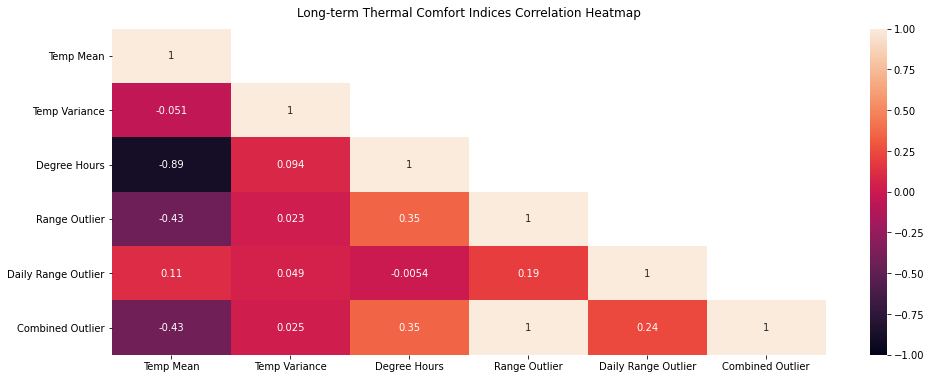

In [40]:
# plot Pearson correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(cor_df.corr(), vmin=-1, vmax=1, annot=True, mask=mask)
heatmap.set_title('Long-term Thermal Comfort Indices Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

## 3. Investigating the range outlier index values
We utilize the relationshiops defined between entities in Brick schema to investigate the problem area and HVAC equipment. First, we randomly select a building. Second, we calculate range outlier index value at each sensor and sort all sensors by their index values. Third, we visualize the Brick models, which disaggreates the index values by zones, floors and equipment. 

In [9]:
meta_bldg = client.sparql(query, sites=['vmif'])
meta_bldg

sensor  \
0      http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2004.Zone_Supply_Air_Flow   
1      http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2016.Zone_Supply_Air_Flow   
2      http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2009.Zone_Supply_Air_Flow   
3      http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM1005.Zone_Supply_Air_Flow   
4      http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM2063.Zone_Supply_Air_Flow   
..                                                                                 ...   
197  http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM2005_2.Zone_Supply_Air_Flow   
198    http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM1001.Zone_Supply_Air_Flow   
199           http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2018.Zone_Air_Temp   
200           http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM2067.Zone_Air_Temp   
201               http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM2061.VLV1_COMD   

                                             zone  \
0      http://buildsys.org/ontologies/VMIF#RM2004   
1      http://buildsys.org/ontologies/VMIF#RM2016   
2      http://buildsys.org/ontologies/VMIF#RM2009   
3      http://buildsys.org/ontologies/VMIF#RM1005   
4      http://buildsys.org/ontologies/VMIF#RM2063   
..                                            ...   
197  http://buildsys.org/ontologies/VMIF#RM2005_2   
198    http://buildsys.org/ontologies/VMIF#RM1001   
199    http://buildsys.org/ontologies/VMIF#RM2018   
200    http://buildsys.org/ontologies/VMIF#RM2067   
201    http://buildsys.org/ontologies/VMIF#RM2061   

                                                 vav  \
0      http://buildsys.org/ontologies/VMIF#VAVRM2004   
1      http://buildsys.org/ontologies/VMIF#VAVRM2016   
2      http://buildsys.org/ontologies/VMIF#VAVRM2009   
3      http://buildsys.org/ontologies/VMIF#VAVRM1005   
4      http://buildsys.org/ontologies/VMIF#VAVRM2063   
..                                               ...   
197  http://buildsys.org/ontologies/VMIF#VAVRM2005_2   
198    http://buildsys.org/ontologies/VMIF#VAVRM1001   
199    http://buildsys.org/ontologies/VMIF#VAVRM2018   
200    http://buildsys.org/ontologies/VMIF#VAVRM2067   
201    http://buildsys.org/ontologies/VMIF#VAVRM2061   

                                                  room  \
0      http://buildsys.org/ontologies/VMIF#RM2004_room   
1      http://buildsys.org/ontologies/VMIF#RM2016_room   
2      http://buildsys.org/ontologies/VMIF#RM2009_room   
3      http://buildsys.org/ontologies/VMIF#RM1005_room   
4      http://buildsys.org/ontologies/VMIF#RM2063_room   
..                                                 ...   
197  http://buildsys.org/ontologies/VMIF#RM2005_2_room   
198    http://buildsys.org/ontologies/VMIF#RM1001_room   
199    http://buildsys.org/ontologies/VMIF#RM2018_room   
200    http://buildsys.org/ontologies/VMIF#RM2067_room   
201    http://buildsys.org/ontologies/VMIF#RM2061_room   

                                          floor  \
0    http://buildsys.org/ontologies/VMIF#floor2   
1    http://buildsys.org/ontologies/VMIF#floor2   
2    http://buildsys.org/ontologies/VMIF#floor2   
3    http://buildsys.org/ontologies/VMIF#floor1   
4    http://buildsys.org/ontologies/VMIF#floor2   
..                                          ...   
197  http://buildsys.org/ontologies/VMIF#floor2   
198  http://buildsys.org/ontologies/VMIF#floor1   
199  http://buildsys.org/ontologies/VMIF#floor2   
200  http://buildsys.org/ontologies/VMIF#floor2   
201  http://buildsys.org/ontologies/VMIF#floor2   

                                           ahu  site  
0    http://buildsys.org/ontologies/VMIF#AHU01  vmif  
1    http://buildsys.org/ontologies/VMIF#AHU01  vmif  
2    http://buildsys.org/ontologies/VMIF#AHU01  vmif  
3    http://buildsys.org/ontologies/VMIF#AHU02  vmif  
4    http://buildsys.org/ontologies/VMIF#AHU02  vmif  
..                                         ...   

In [13]:
inv = []
for idxi, row in meta_bldg.iterrows():
    inv_row = {}
    md = row.sensor
    md_end = re.split('[.]', md)[-1]
    if md_end == "Zone_Air_Temp":
        # calculate indices
        i_ro = range_outlier(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
        # assign each index values to a column in the dictionary
        for k in meta_bldg.columns:
            inv_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        inv_row['Range Outlier'] = i_ro
        inv += [inv_row]
    else:
        continue
inv_df = pd.DataFrame(inv).sort_values(['Range Outlier'], ascending=[False])
inv_df.head(10)

sensor      zone          vav           room   floor    ahu  site  \
44  Zon_Air_Temp    RM2063    VAVRM2063    RM2063_room  floor2  AHU02  vmif   
8   Zon_Air_Temp  RM1030_1  VAVRM1030_1  RM1030_1_room  floor1  AHU02  vmif   
31  Zon_Air_Temp    RM2048    VAVRM2048    RM2048_room  floor2  AHU02  vmif   
49  Zon_Air_Temp    RM1056    VAVRM1056    RM1056_room  floor1  AHU02  vmif   
20  Zon_Air_Temp    RM2054    VAVRM2054    RM2054_room  floor2  AHU02  vmif   
19  Zon_Air_Temp    RM2052    VAVRM2052    RM2052_room  floor2  AHU02  vmif   
14  Zon_Air_Temp    RM1006    VAVRM1006    RM1006_room  floor1  AHU01  vmif   
39  Zon_Air_Temp    RM1044    VAVRM1044    RM1044_room  floor1  AHU02  vmif   
45  Zon_Air_Temp    RM2044    VAVRM2044    RM2044_room  floor2  AHU02  vmif   
27  Zon_Air_Temp    RM1052    VAVRM1052    RM1052_room  floor1  AHU02  vmif   

    Range Outlier  
44           1.00  
8            0.65  
31           0.58  
49           0.56  
20           0.56  
19           0.54  
14           0.53  
39           0.50  
45           0.50  
27           0.50

![alt text](brickinstancemodel.png "Title")

## 4. Overcooling and overheating evaluation metrics
The range outlier index I_ro does notdoesn't differentiate whether the temperature is higher or lower than the range. Therefore, we developed two new metrics to calculate the percentage of overheating outliers I_oh and the percentage of overcooling outliers I_oc. We randomly select a building and calculate range outlier index value, overheating outlier index value, and overcooling outlier index value at each sensor.

In [11]:
meta_bldg = client.sparql(query, sites=['stor'])
meta_bldg

sensor  \
0     http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU03.RM3346.Zone_Air_Temp   
1    http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU02.RM2320H.Zone_Air_Temp   
2     http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU05.RM5326.Zone_Air_Temp   
3     http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU06.RM6342.Zone_Air_Temp   
4     http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU06.RM6349.Zone_Air_Temp   
..                                                                         ...   
102   http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU05.RM5349.Zone_Air_Temp   
103   http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU04.RM4342.Zone_Air_Temp   
104   http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU06.RM6322.Zone_Air_Temp   
105   http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU04.RM4350.Zone_Air_Temp   
106   http://buildsys.org/ontologies/STOR#STOR.ZONE.AHU03.RM3337.Zone_Air_Temp   

                                            zone  \
0     http://buildsys.org/ontologies/STOR#RM3346   
1    http://buildsys.org/ontologies/STOR#RM2320H   
2     http://buildsys.org/ontologies/STOR#RM5326   
3     http://buildsys.org/ontologies/STOR#RM6342   
4     http://buildsys.org/ontologies/STOR#RM6349   
..                                           ...   
102   http://buildsys.org/ontologies/STOR#RM5349   
103   http://buildsys.org/ontologies/STOR#RM4342   
104   http://buildsys.org/ontologies/STOR#RM6322   
105   http://buildsys.org/ontologies/STOR#RM4350   
106   http://buildsys.org/ontologies/STOR#RM3337   

                                                vav  \
0     http://buildsys.org/ontologies/STOR#VAVRM3346   
1    http://buildsys.org/ontologies/STOR#VAVRM2320H   
2     http://buildsys.org/ontologies/STOR#VAVRM5326   
3     http://buildsys.org/ontologies/STOR#VAVRM6342   
4     http://buildsys.org/ontologies/STOR#VAVRM6349   
..                                              ...   
102   http://buildsys.org/ontologies/STOR#VAVRM5349   
103   http://buildsys.org/ontologies/STOR#VAVRM4342   
104   http://buildsys.org/ontologies/STOR#VAVRM6322   
105   http://buildsys.org/ontologies/STOR#VAVRM4350   
106   http://buildsys.org/ontologies/STOR#VAVRM3337   

                                                 room  \
0     http://buildsys.org/ontologies/STOR#RM3346_room   
1    http://buildsys.org/ontologies/STOR#RM2320H_room   
2     http://buildsys.org/ontologies/STOR#RM5326_room   
3     http://buildsys.org/ontologies/STOR#RM6342_room   
4     http://buildsys.org/ontologies/STOR#RM6349_room   
..                                                ...   
102   http://buildsys.org/ontologies/STOR#RM5349_room   
103   http://buildsys.org/ontologies/STOR#RM4342_room   
104   http://buildsys.org/ontologies/STOR#RM6322_room   
105   http://buildsys.org/ontologies/STOR#RM4350_room   
106   http://buildsys.org/ontologies/STOR#RM3337_room   

                                          floor  \
0    http://buildsys.org/ontologies/STOR#floor3   
1    http://buildsys.org/ontologies/STOR#floor2   
2    http://buildsys.org/ontologies/STOR#floor5   
3    http://buildsys.org/ontologies/STOR#floor6   
4    http://buildsys.org/ontologies/STOR#floor6   
..                                          ...   
102  http://buildsys.org/ontologies/STOR#floor5   
103  http://buildsys.org/ontologies/STOR#floor4   
104  http://buildsys.org/ontologies/STOR#floor6   
105  http://buildsys.org/ontologies/STOR#floor4   
106  http://buildsys.org/ontologies/STOR#floor3   

                                           ahu  site  
0    http://buildsys.org/ontologies/STOR#AHU03  stor  
1    http://buildsys.org/ontologies/STOR#AHU02  stor  
2    http://buildsys.org/ontologies/STOR#AHU05  stor  
3    http://buildsys.org/ontologies/STOR#AHU06  stor  
4    http://buildsys.org/ontologies/STOR#AHU06  stor  
..                                         ...   ...  
102  http://buildsys.org/ontologies/STOR#AHU05  stor  
103  http://buildsys.org/ontologies/STOR#AHU04  stor  
104  htt

In [57]:
from overheating_outlier import *
from overcooling_outlier import *
diag = []
for idxi, row in meta_bldg.iterrows():
    diag_row = {}
    md = row.sensor
    md_end = re.split('[.]', md)[-1]
    if md_end == "Zone_Air_Temp":
        # calculate indices
        i_ro = range_outlier(md, ss, ws, sd, ed, sh, eh, sl, su, wl, wu)
        i_oc = overcooling_outlier(md, ss, ws, sd, ed, sh, eh, sl, wl)
        i_oh = overheating_outlier(md, ss, ws, sd, ed, sh, eh, su, wu)
        # assign each index values to a column in the dictionary
        for k in meta_bldg.columns:
            diag_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        diag_row['Range Outlier'] = i_ro
        diag_row['Overcooling Outlier'] = i_oc
        diag_row['Overheating Outlier'] = i_oh
        diag += [diag_row]
    else:
        print(md_end)
diag_df = pd.DataFrame(diag)
diag_df

sensor     zone         vav          room   floor    ahu  site  \
0    Zon_Air_Temp   RM3346   VAVRM3346   RM3346_room  floor3  AHU03  stor   
1    Zon_Air_Temp  RM2320H  VAVRM2320H  RM2320H_room  floor2  AHU02  stor   
2    Zon_Air_Temp   RM5326   VAVRM5326   RM5326_room  floor5  AHU05  stor   
3    Zon_Air_Temp   RM6342   VAVRM6342   RM6342_room  floor6  AHU06  stor   
4    Zon_Air_Temp   RM6349   VAVRM6349   RM6349_room  floor6  AHU06  stor   
..            ...      ...         ...           ...     ...    ...   ...   
102  Zon_Air_Temp   RM5349   VAVRM5349   RM5349_room  floor5  AHU05  stor   
103  Zon_Air_Temp   RM4342   VAVRM4342   RM4342_room  floor4  AHU04  stor   
104  Zon_Air_Temp   RM6322   VAVRM6322   RM6322_room  floor6  AHU06  stor   
105  Zon_Air_Temp   RM4350   VAVRM4350   RM4350_room  floor4  AHU04  stor   
106  Zon_Air_Temp   RM3337   VAVRM3337   RM3337_room  floor3  AHU03  stor   

     Range Outlier  Overcooling Outlier  Overheating Outlier  
0             0.04                 0.04                 0.00  
1             0.03                 0.03                 0.00  
2             0.01                 0.00                 0.00  
3             0.11                 0.11                 0.00  
4             0.00                 0.00                 0.00  
..             ...                  ...                  ...  
102           0.01                 0.01                 0.00  
103           0.51                 0.51                 0.00  
104           0.04                 0.04                 0.00  
105           0.43                 0.43                 0.01  
106           0.00                 0.00                 0.00  

[107 rows x 10 columns]

we further aggregated these sensors’ index values at AHU and Floor levels, shown in the two dataframes below. The floor value is the average of all air temperature sensors located on that floor, and the AHU value is the average of all air temperature sensors that the AHU feeds.

In [89]:
diag_df.groupby(by=["floor"]).mean().round(2)

I_ro  I_oc  I_oh
floor                   
floor0  0.05  0.03  0.02
floor1  0.22  0.21  0.01
floor2  0.14  0.13  0.00
floor3  0.16  0.12  0.04
floor4  0.13  0.13  0.00
floor5  0.08  0.08  0.00
floor6  0.14  0.13  0.01

In [90]:
diag_df.groupby(by=["ahu"]).mean().round(2)

I_ro  I_oc  I_oh
ahu                    
AHU00  0.04  0.03  0.01
AHU01  0.24  0.24  0.01
AHU02  0.14  0.13  0.00
AHU03  0.16  0.12  0.04
AHU04  0.13  0.13  0.00
AHU05  0.08  0.08  0.00
AHU06  0.14  0.13  0.01